In [51]:
import blosum as bl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns

from Bio import SeqIO
from Bio.SeqRecord import Seq
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import MinMaxScaler

In [3]:
# setting the color palette for the figures
sns.set_palette(palette = 'muted')

# Prepping MSA sequence data

In [4]:
# reading in the fasta file as a dictionary where
# key = accession, and value = sequence as a Bio.Seq item
seq_dict = SeqIO.to_dict(SeqIO.parse('./msa.fasta', 'fasta'))

In [5]:
# parsing the reference phoP and PhoR sequence from files containing
# DNA and protein sequence
phopr_dna = SeqIO.to_dict(SeqIO.parse('./phopr_dna.fasta', 'fasta'))
phopr_aa = SeqIO.to_dict(SeqIO.parse('./phopr_aa.fasta', 'fasta'))

# converting from Bio.seq to string
phop_dna = str(phopr_dna['phoP|H37Rv'].seq)
phor_dna = str(phopr_dna['phoR|H37Rv'].seq)

phop_aa = str(phopr_aa['phoP|H37Rv'].seq)
phor_aa = str(phopr_aa['phoR|H37Rv'].seq)

# making a new variable containing the reference sequence containing phoPR + flanks
reference = str(seq_dict['reference'].seq)
print(f'phoP starts at: {reference.find(phop_dna)}  bp, with {len(phop_dna)} bp total\
      \nphoR starts at: {reference.find(phor_dna)} bp, with {len(phor_dna)} bp total')

phoP starts at: 499  bp, with 744 bp total      
phoR starts at: 1287 bp, with 1458 bp total


## Preparing reference sequence and amino acid dictionaries

In [6]:
# converting reference phoP and phop DNA sequences into codons
# by making a list grouping three nucleotides as one item
ref_phop_codons = [phop_dna[i:i+3] for i in range(0, len(phop_dna), 3)]
ref_phor_codons = [phor_dna[i:i+3] for i in range(0, len(phor_dna), 3)]

In [7]:
# making a dictionary containing each aa and their subgroup
aa_types = {'nonpolar':         ['L', 'I', 'V', 'A', 'M', 'F', 'W', 'P', 'G'],
            'polar/uncharged':  ['S', 'N', 'Q', 'T', 'C', 'Y'],
            'acidic':           ['D', 'E'],
            'basic':            ['K', 'R', 'H']}

aa_inv = {}

# inverting dictionary so amino acids become keys
for key in aa_types.keys():
    for item in aa_types[key]:
        aa_inv[item] = key

aa_types = aa_inv

# Functions

In [8]:
# function to compare DNA sequences and codons between reference sequence
# and another sequence (from sequence dictionary). This results in a df containing al SNP's on a DNA level
# and a different df containing all differences on a protein level, including if the mutation is synonymous, non-synonymous, etc.

def codon_comp(reference_codons, reference_prot_seq, sequence_codons, sequence, mutation_nt_dict, mutation_aa_dict, del_loc):
    # setting counters to 0
    n_snp = 0
    n_codonchange = 0
    n_synonymous = 0
    n_missense = 0
    n_nonsense = 0
    
    # translating non-reference DNA sequence
    # has to be a Bio.Seq type first otherwise it can't be translated
    prot_seq = Seq(sequence).replace('-', '').translate(gap = '-', to_stop=True)

    # if the protein sequence (minus stop codon)
    # is longer than the reference protein seq
    # it should be noted that the stop codon was (re)moved
    if len(prot_seq) -1 > len(reference_codons):
            print('Stop codon has been moved!')
    # removing stop codon from other sequences(not included in reference sequences)
    else:
         prot_seq = prot_seq[:-1]

    # if there are deletions in the sequence
    # only consider the part of the sequence before a codon with a deletion occurs
    if del_loc != False:
        seq_len = int(del_loc[0] / 3)
    else: seq_len = len(prot_seq)          
    
    for i in range(seq_len):
        if i <= len(reference_prot_seq): # only continue until the length of reference protein sequence
            # see first if the reference codon and the sequence codon are equal, and if there is not an n present
            if str(reference_codons[i]) != str(sequence_codons[i]) and 'n' not in str(sequence_codons[i]):
                n_codonchange +=1
                for index, nucleotide_seq in enumerate(sequence_codons[i]):
                    nucleotide_ref = reference_codons[i][index]
                    if nucleotide_seq != nucleotide_ref: # adds to nucleotide dictionary containing all SNPs
                        n_snp += 1
                        mutation_nt_dict[i*3 + index] = mutation_nt_dict[i*3 + index] + [f'{nucleotide_ref} -> {nucleotide_seq}']

                if reference_prot_seq[i] == prot_seq[i]: # synonymous
                    n_synonymous += 1
                    mutation_aa_dict[i] = mutation_aa_dict[i] + [f'{reference_codons[i]} -> {sequence_codons[i]},{reference_prot_seq[i]} -> {prot_seq[i]},synonymous']
                elif prot_seq[i] != '*': # find missense mutations
                    n_missense += 1
                    # find if protein is still conservative or non-conservative
                    if aa_types[prot_seq[i]] != aa_types[reference_prot_seq[i]]: 
                        type = 'non-conservative'
                    else:
                        type = 'conservative'
                    mutation_aa_dict[i] = mutation_aa_dict[i] + [f'{reference_codons[i]} -> {sequence_codons[i]},{reference_prot_seq[i]} -> {prot_seq[i]},{type}']
                elif prot_seq[i] == '*': # find nonsense mutations
                    n_nonsense += 1
                    mutation_aa_dict[i] = mutation_aa_dict[i] + [f'{reference_codons[i]} -> {sequence_codons[i]},{reference_prot_seq[i]} -> {prot_seq[i]},nonsense']
                    break

    # returns all counts     
    return n_codonchange, n_snp, n_synonymous, n_missense, n_nonsense

In [9]:
# function that finds deletions '-' in sequences and returns a list containing the indices
# or False if there are no deletions
def find_dels(sequence):
    index = 0
    del_loc = []
    while index < len(sequence):
        index = sequence.find('-', index)
        if index == -1:
            break           
        del_loc.append(index)
        index = index + 1

    if del_loc == []:
        del_loc = False
    return del_loc

In [10]:
# function that creates a dictionaries with a key for each position the sequence
def prot_dict_making(target_len):
    dict = {}
    for i in range(len(target_len)):
        dict[i] = []
    return dict

In [11]:
# function that makes pandas dataframes out of the previous dictionaries
def mutation_dict_to_df(mutation_dict, type = 'aa'):
    data = {}
    types = ['aa', 'nt'] # df columns depend on type of dictionary

    if type not in types:
        raise ValueError('invalid type, type should be \'aa\' or \'nt\'')
    
    elif type == 'aa': # setting column names
        data['position'] = []
        data['change_dna'] = []
        data['change_aa'] = []
        data['type'] = []
        data['occurrences'] = []

    elif type == 'nt': # setting column names
        data['position'] = []
        data['change'] = []
        data['occurrences'] = []
    
    # for each position in the sequence count the number
    # of occurences of one mutation and add this + the type to the dataframe
    for position in range(len(reference)): 
        if position in mutation_dict:
            changes = set(mutation_dict[position])
            for change in changes:
                occurrences = mutation_dict[position].count(change)
                if type == 'aa':
                    change_dna, change_aa, m_type = change.split(',')

                    data['position'].append(position)
                    data['change_dna'].append(change_dna)
                    data['change_aa'].append(change_aa)
                    data['type'].append(m_type)
                    data['occurrences'].append(occurrences)
                    
                elif type == 'nt':
                    data['position'].append(position)
                    data['change'].append(change)
                    data['occurrences'].append(occurrences)

    df = pd.DataFrame.from_dict(data)
    return df

In [12]:
# function that merges nt and aa dfs
def merge_nt_aa_df(aa_df, nt_df):
    # copying dfs and changing column names for clear identification        
    aa_df_temp = aa_df.copy(deep = True)
    aa_df_temp.rename(columns = {'position': 'aa_position'}, inplace = True)

    nt_df_temp = nt_df.copy(deep = True)
    nt_df_temp.rename(columns = {'position': 'nt_position'}, inplace = True)
    # convert nt positions to aa positions to merge dfs 
    nt_df_temp['aa_position'] = (nt_df_temp['nt_position'] / 3).apply(lambda x: int(x)) 

    merged_df = pd.merge(nt_df_temp, aa_df_temp, on= "aa_position", how = 'left').reindex()

    # deleting superfluous rows that were created during merging, because one codon was changed 2 or more times 
    # in different ways, this for loop checks if the change (t -> a e.g.) matches the DNA change 
    # in the codon (tca -> aca e.g.). If not, this row was created as an artefact during merging
    # and will be removed
    drop_rows = []
    for i in merged_df.index:
        codon1 = merged_df['change_dna'][i].split(' ')[0]
        codon2 = merged_df['change_dna'][i].split(' ')[2]
        
        # finding nt position within codon
        nt_position = merged_df['nt_position'][i] % 3

        # see if change in 'change'column matches change in 'change_dna'column
        if codon1[nt_position] != merged_df['change'][i][0] or codon2[nt_position] != merged_df['change'][i][-1]:
                drop_rows.append(i)
    merged_df.drop(drop_rows, inplace = True)
 
    merged_df.reset_index(drop = True, inplace = True)
    #merged_df['nt_position'] = merged_df['nt_position'].astype(float)


    # keep only the amino acid occurence to show the times a certain nt change led to a different amino acid
    # otherwise the counts are off
    merged_df.drop('occurrences_x', inplace = True, axis = 1)
    merged_df.rename(columns = {'occurrences_y': 'occurrences'}, inplace = True) # keep the occurences from the aa table

    return merged_df

In [13]:
# function that adds an empty row for each nt position that does not have a mutation for 
# barplots
def add_empty_rows(seq_ref, merged_df):
    for i in range(len(seq_ref)):
        if i not in list(merged_df['nt_position']):
            merged_df.loc[len(merged_df)+5000] = {'nt_position': float(i), 'change': np.nan, 'aa_position': np.nan,
                                   'change_dna': np.nan, 'change_aa': np.nan, 'type': np.nan, 'occurrences': 0}
    
    merged_df.sort_values(by=['nt_position'], ignore_index=True, inplace = True)

In [14]:
# function that makes a new df from aa df containing only non-synonymous mutations
# also scales values

def simple_df(df:pd.DataFrame, to_drop:list|str, protein_seq:str|Seq):
    sum_df = df.copy(deep = True)
    sum_df = sum_df[sum_df['type'] != 'synonymous'].drop('change_dna', axis = 1).set_index('position')

    sum_df = sum_df.drop(to_drop, axis = 1)
    for i in range(len(protein_seq)):
        if i not in sum_df.index:
            sum_df.loc[i] = 0

    sum_df = sum_df.groupby(sum_df.index[:]).sum()

    scaler = MinMaxScaler()
    scaler.fit(sum_df)

    sum_df['scaled values'] = scaler.transform(sum_df)

    return sum_df

In [15]:
# function that makes a .defattr file for ChimeraX for either PIPENN 
# or mut freq scores
def make_defattr(df:pd.DataFrame, attribute_name:str, file_name:str, column:str, protein:str):
    if file_name.endswith('.defattr'):
        f = open('../../structures/'+file_name, 'w')
    else:
        f = open('../../structures/'+file_name+'.defattr', 'w')
    
    input = f'# Mutation totals from {protein} derived from {attribute_name}\n# Use this file to add the attribute to a protein using Chimera X\nattribute: {attribute_name}\nmatch mode: 1-to-1\nrecipient: residues\n'

    for i in range(len(df)):
        input += f'\t:{i+1}\t{df[column][i]}\n'

    f.write(input)
    f.close()

# Applying the comparison and deletion functions on every sequence

In [16]:
sums_phop = np.array([0, 0, 0, 0, 0])
sums_phor = np.array([0, 0, 0, 0, 0])

# making empty lists that will later contain the number of n's per sequence (phoP and phoR)
num_n_seq = []
num_n_phop = []
num_n_phor = []

# empty list to store the accessions of sequences that were removed for having too many 'n's
removed_n = []

# making empty dictionaries to store the mutations per sequence on a protein and DNA level
mutation_dict_phop_nt = prot_dict_making(phop_dna)
mutation_dict_phop_aa = prot_dict_making(phop_aa)

mutation_dict_phor_nt = prot_dict_making(phor_dna)
mutation_dict_phor_aa = prot_dict_making(phor_aa)


# looping over every sequence in dictionary to compare to reference
for key in seq_dict:
    if key != 'reference':
        sequence = seq_dict[key].seq

        # extracting the phop and phor sequences from the locus
        sequence_phop_dna = str(sequence[499: 499 + len(phop_dna)])
        sequence_phor_dna = str(sequence[1287:1287 + len(phor_dna) +3])

        # splitting DNA sequence into codons
        seq_phop_codons = [sequence_phop_dna[i:i+3] for i in range(0, len(sequence_phop_dna), 3)]
        seq_phor_codons = [sequence_phor_dna[i:i+3] for i in range(0, len(sequence_phor_dna), 3)]
        
        # ignore sequences with more than 5 'n's
        if (sequence_phop_dna.count('n') + sequence_phor_dna.count('n')) > 5:
            pass

        # checking whether there is a stop codon in the sequence
        # if there is no stop codon, the sequence until the end of the right flank is considered
        # during BioSeq translation, the sequence will be translated up to the stop codon
        elif seq_phor_codons.count('taa') + seq_phor_codons.count('tga') + seq_phor_codons.count('tag') == 0:
            sequence_phor_dna = str(sequence[1287:])
            seq_phor_codons = [sequence_phor_dna[i:i+3] for i in range(0, len(sequence_phor_dna), 3)]

        # Go until there is a stop codon, in case it has been moved through a deletion
        # not the case here but maybe in the future
        elif seq_phor_codons[-2] not in ['taa', 'tga', 'tag']:
            for stop_codon in ['taa', 'tga', 'tag']:
                if stop_codon in seq_phor_codons:
                    stop_location = seq_phor_codons.index(stop_codon)
            seq_phor_codons = seq_phor_codons[:stop_location]
            
        if (sequence_phop_dna.count('n') + sequence_phor_dna.count('n')) > 5:
            removed_n.append(key)

        elif (sequence_phop_dna.count('n') + sequence_phor_dna.count('n')) <= 5:
            # apply find_dels function on both sequences
            del_loc_phop = find_dels(sequence_phop_dna)
            del_loc_phor = find_dels(sequence_phor_dna)

            # printing deletions
            if del_loc_phop or del_loc_phor:
                print(f'{key}\n\tPhoP deletions: {del_loc_phop}\n\tPhoR deletions: {del_loc_phor}\n')

            # use codon comp function to compare sequences and add to the sum total of mutations 
            sums_phop = sums_phop + codon_comp(ref_phop_codons, phop_aa, seq_phop_codons, sequence_phop_dna,
                                               mutation_dict_phop_nt, mutation_dict_phop_aa, del_loc_phop)
            
            sums_phor = sums_phor + codon_comp(ref_phor_codons, phor_aa, seq_phor_codons, sequence_phor_dna,
                                               mutation_dict_phor_nt, mutation_dict_phor_aa, del_loc_phor)

            num_n_seq.append(sequence.count('n'))
            num_n_phop.append(sequence_phop_dna.count('n'))
            num_n_phor.append(sequence_phor_dna.count('n'))

ERR017778|phoPR
	PhoP deletions: False
	PhoR deletions: [270, 271, 272, 273, 274, 275, 276, 277, 278, 279]

ERR019852|phoPR
	PhoP deletions: False
	PhoR deletions: [270, 271, 272, 273, 274, 275, 276, 277, 278, 279]



c:\Users\ingi1\anaconda3\Lib\site-packages\Bio\Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


ERR234151|phoPR
	PhoP deletions: False
	PhoR deletions: [272, 273, 274, 275, 276, 277, 278, 279, 280, 281]



In [17]:
# printing totals overview
print(f'\nTotal number of sequences removed: {len(removed_n)}\n')

print(f'phoP:\n \tSNPs: \t\t\t\t{sums_phop[1]}\n \tsynonymous mutations:\t\t{sums_phop[2]}\
      \n \tnon-synonymous mutations:\t{sums_phop[3]}\n \tnonsense mutations:\t\t{sums_phop[4]}')

print(f'phoR:\n \tSNPs: \t\t\t\t{sums_phor[1]}\n \tsynonymous mutations:\t\t{sums_phor[2]}\
      \n \tnon-synonymous mutations:\t{sums_phor[3]}\n \tnonsense mutations:\t\t{sums_phor[4]}')

print(f'\n\nThe number of \'n\'s in \nThe entire sequence:\t{sum(num_n_seq)}',
      f'\nPhoP:\t\t\t{sum(num_n_phop)} \nPhoR:\t\t\t{sum(num_n_phor)}')


Total number of sequences removed: 95

phoP:
 	SNPs: 				35
 	synonymous mutations:		21      
 	non-synonymous mutations:	14
 	nonsense mutations:		0
phoR:
 	SNPs: 				3662
 	synonymous mutations:		173      
 	non-synonymous mutations:	3438
 	nonsense mutations:		0


The number of 'n's in 
The entire sequence:	2312 
PhoP:			18 
PhoR:			1664


## Storing sequence names with more than 5 'n's

In [ ]:
#  FOR THIS CELL TO RUN PROPERLY, THE ALL_CONSENSUS FOLDER SHOULD BE UNZIPPED

# saving the complete (file) names of the sequences that were removed
# for having more than 5 'n's as a csv file
removed_n_df = []
removed_n_dict = {}
accession_dict = {}
[removed_n_df.append(i.split('|')[0]) for i in removed_n]

for accession in os.listdir('../all_consensus'):
    removed_n_dict[accession] = []
    accession_dict[accession] = [i.removeprefix('aln_').removesuffix('.fasta') for i in os.listdir(f'../all_consensus/{accession}/consensus')]

# making seperate columns per study accesssion
for i in removed_n_df:
    for accession in accession_dict.keys():
        if i in accession_dict[accession]:
            removed_n_dict[accession].append(i)

removed_n_df = pd.DataFrame.from_dict(removed_n_dict, orient = 'index').transpose()
removed_n_df.to_csv('./removed_n.csv')


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../all_processed'

In [18]:
# saving a seperate file that includes only the sequence numbers
# in a single row
raw_removed_n_df = []
[raw_removed_n_df.append(i.split('|')[0]) for i in removed_n]

raw_removed_n_df = pd.DataFrame(raw_removed_n_df)
raw_removed_n_df.to_csv('./raw_removed_n.csv')

In [19]:
# storing removed 'n' sequence names
%store removed_n

Stored 'removed_n' (list)


# Converting dictionaries into dataframes

In [20]:
# applying mutation_dict_to_df function to previously made dictionaries
phop_nt_df = mutation_dict_to_df(mutation_dict_phop_nt, type = 'nt')
phop_aa_df = mutation_dict_to_df(mutation_dict_phop_aa, type = 'aa')

phor_nt_df = mutation_dict_to_df(mutation_dict_phor_nt, type = 'nt')
phor_aa_df = mutation_dict_to_df(mutation_dict_phor_aa, type = 'aa')

## Merging amino acid and nt dataframes

In [21]:
merged_phop_df = merge_nt_aa_df(phop_aa_df, phop_nt_df)
merged_phor_df = merge_nt_aa_df(phor_aa_df, phor_nt_df)

In [22]:
# print complete merged_phop_df
with pd.option_context('display.max_rows', None): 
    print(merged_phop_df)

    nt_position  change  aa_position  change_dna change_aa              type  \
0            19  t -> g            6  ctc -> cgc    L -> R  non-conservative   
1            36  c -> a           12  cca -> aca    P -> T  non-conservative   
2            93  a -> g           31  atc -> gtc    I -> V      conservative   
3           143  c -> t           47  tac -> tat    Y -> Y        synonymous   
4           189  c -> a           63  cgg -> agg    R -> R        synonymous   
5           218  g -> a           72  atg -> ata    M -> I      conservative   
6           236  c -> a           78  ggc -> gga    G -> G        synonymous   
7           267  g -> c           89  ggc -> cgc    G -> R  non-conservative   
8           274  a -> c           91  gat -> gct    D -> A  non-conservative   
9           311  a -> g          103  cta -> ctg    L -> L        synonymous   
10          371  t -> g          123  agt -> agg    S -> R  non-conservative   
11          405  c -> g          135  ct

In [23]:
# print complete merged_phor_df
with pd.option_context('display.max_rows', None): 
    print(merged_phor_df)

     nt_position  change  aa_position  change_dna change_aa              type  \
0             54  a -> g           18  acg -> gcg    T -> A  non-conservative   
1             55  c -> t           18  acg -> atg    T -> M  non-conservative   
2             88  c -> t           29  tcg -> ttg    S -> L  non-conservative   
3             90  g -> t           30  ggg -> tgg    G -> W      conservative   
4             99  g -> t           33  gtc -> ttc    V -> F      conservative   
5            109  t -> c           36  atg -> acg    M -> T  non-conservative   
6            146  g -> a           48  gtg -> gta    V -> V        synonymous   
7            147  t -> g           49  ttg -> gtg    L -> V      conservative   
8            168  t -> a           56  tgg -> agg    W -> R  non-conservative   
9            175  a -> c           58  cag -> ccg    Q -> P  non-conservative   
10           186  c -> t           62  ccc -> tcc    P -> S  non-conservative   
11           210  g -> a    

In [24]:
# comparing to previous counts
print(f'Number of mutations in phoP sequence: {merged_phop_df['occurrences'].sum()}\n\
Number of mutations in PhoR sequence: {merged_phor_df['occurrences'].sum()}\n\
Combined total: {merged_phop_df['occurrences'].sum() + merged_phor_df['occurrences'].sum()}')

Number of mutations in phoP sequence: 35
Number of mutations in PhoR sequence: 3662
Combined total: 3697


In [25]:
len(seq_dict.keys())

3246

## Completing DFs


In [26]:
add_empty_rows(phop_dna, merged_phop_df)
add_empty_rows(phor_dna, merged_phor_df)

In [27]:
# printing most common mutation
merged_phor_df[merged_phor_df['nt_position'] == 514] 

,nt_position,change,aa_position,change_dna,change_aa,type,occurrences
515,514.0,c -> t,171.0,ccc -> ctc,P -> L,conservative,3135


# PhoP sequence plot

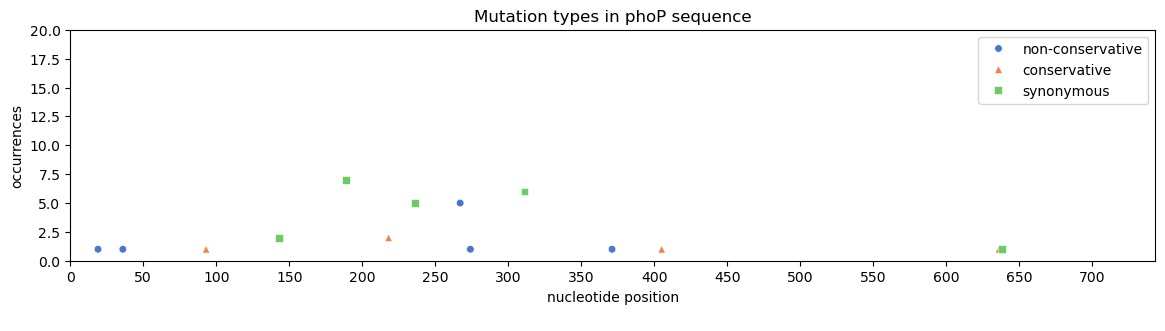

In [28]:
#phop plot
fig, ax = plt.subplots(figsize=(14, 3))

sns.scatterplot(x = merged_phop_df.index, y = merged_phop_df['occurrences'], hue = merged_phop_df['type'], style = merged_phop_df['type'], 
                markers = ['o', '^', 's'], s = 30)

ax.xaxis.set_major_locator(MultipleLocator(50))
ax.set_title('Mutation types in phoP sequence')
ax.set_xlabel('nucleotide position')
ax.set_xlim(0, 743)
ax.set_ylim(0, 20)

# adding empty annotation so the figure has same dimensions as other plots
trans = ax.get_xaxis_transform()
ax.annotate(' ', xy=(1, -.2), xycoords=trans, ha="center", va="top")
plt.legend()
plt.show()

# PhoR sequence plots

## PhoR plot with split y-axis // NOT USED

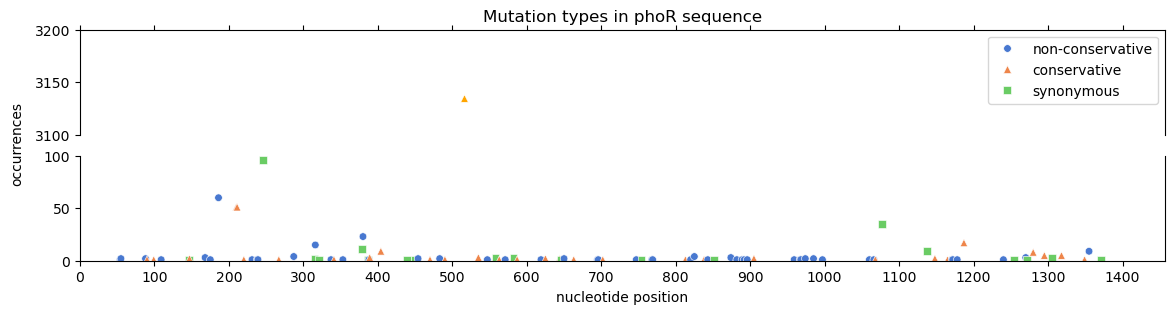

In [29]:
#OLD phor plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(14, 3))

sns.scatterplot(x = merged_phor_df.index, y = merged_phor_df['occurrences'], hue = merged_phor_df['type'], style = merged_phor_df['type'], 
                markers = ['o', '^', 's'], ax = ax2, s = 30)
sns.scatterplot(x = merged_phor_df.index, y = merged_phor_df['occurrences'], color = 'orange', marker = '^', ax = ax1, s = 30)

ax1.xaxis.tick_top()
  
ax1.xaxis.set_major_locator(MultipleLocator(100))
ax2.xaxis.set_major_locator(MultipleLocator(100))

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_ylabel('')
ax2.set_ylabel('')

ax1.set_title('Mutation types in phoR sequence')
ax2.set_xlabel('nucleotide position')
ax1.set_xlim(0, 1457)
ax2.set_xlim(0, 1457)

ax1.set_ylim(3100, 3200)
ax2.set_ylim(0, 100)

fig.text(0.075, 0.5, 'occurrences', va='center', rotation='vertical')



handles, labels = ax2.get_legend_handles_labels()
ax1.legend(handles, labels)
legend = ax2.legend()
legend.remove()

plt.show()

## PhoR final plot

In [30]:
# removing the outlier from the df, and making a neew df containing only the outlier to plot seperately
outlier_loc = merged_phor_df.sort_values(by = 'occurrences', ascending = False).index[0]

outlier_df = pd.DataFrame(merged_phor_df.iloc[[outlier_loc]]) # df with only outlier
phor_no_outlier_df = merged_phor_df.copy(deep = True)         # df without outlier
phor_no_outlier_df.loc[outlier_loc] = None

# changing the outlier value to 98 so it fits onto the plot
outlier_edit_df = outlier_df.copy(deep = True)
outlier_edit_df['occurrences'] = 98
outlier_edit_df

,nt_position,change,aa_position,change_dna,change_aa,type,occurrences
515,514.0,c -> t,171.0,ccc -> ctc,P -> L,conservative,98


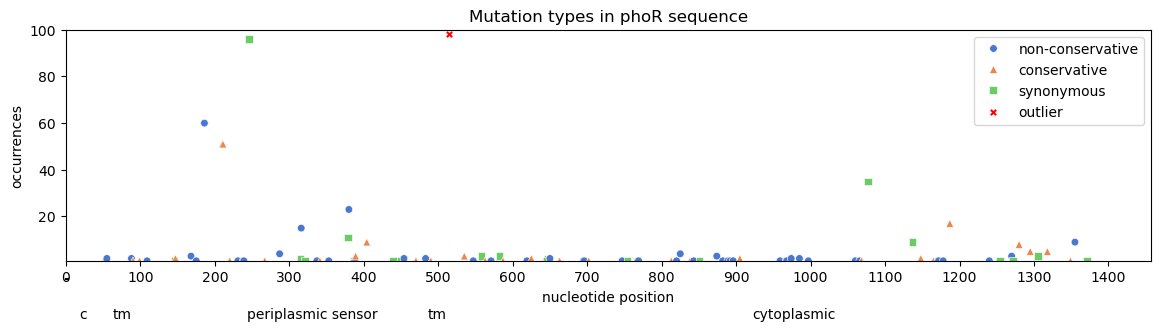

In [31]:
#phor plot
fig, ax1 = plt.subplots(figsize = (14, 3))

sns.scatterplot(x = merged_phor_df.index, y = merged_phor_df['occurrences'], hue = merged_phor_df['type'], style = merged_phor_df['type'], 
                markers = ['o', '^', 's'], ax = ax1, s = 30)
sns.scatterplot(x = outlier_edit_df.index, y = outlier_edit_df['occurrences'], marker = 'X', color = 'red', ax = ax1, s = 30, label = 'outlier')

ax1.xaxis.set_major_locator(MultipleLocator(100))

ax1.set_title('Mutation types in phoR sequence')
ax1.set_xlabel('nucleotide position')
ax1.set_xlim(0, 1457)

# adding annotations
trans = ax1.get_xaxis_transform()
ax1.plot([-.4,2.4],[-.08,-.08], color="k", transform=trans, clip_on=False)
ax1.annotate('periplasmic sensor', xy=((155 * 3-66 * 3)/2 + 66* 3, -.2), xycoords=trans, ha="center", va="top")
ax1.annotate('c', xy=((14 * 3 - 1 * 3)/2 + 1* 3, -.2), xycoords=trans, ha="center", va="top")
ax1.annotate('tm', xy=((36 *3 - 14 * 3)/2 + 14* 3, -.2), xycoords=trans, ha="center", va="top")
ax1.annotate('tm', xy=((177 *3 - 155 * 3)/2 + 155* 3, -.2), xycoords=trans, ha="center", va="top")
ax1.annotate('cytoplasmic', xy=((475 *3 - 177 * 3)/2 + 177* 3, -.2), xycoords=trans, ha="center", va="top")

ax1.set_ylim(1, 100)
plt.margins(x=0,y=1666)

plt.legend()
plt.show()

# Barplots summarizing mutation types

In [32]:
# making summary dfs containing only the number of mutation types per protein
phop_summary_df = phop_aa_df.groupby('type').sum('occurrences').drop('position', axis = 1).T
phor_summary_df = phor_aa_df.groupby('type').sum('occurrences').drop('position', axis = 1).T

phor_summary_no_outlier_df = phor_summary_df.copy(deep = True) # summary df without the outlier
phor_summary_no_outlier_df['conservative'] = phor_summary_no_outlier_df['conservative'] - 3135

phor_summary_only_outlier_df = phor_summary_df.copy(deep = True) # summary df with only the outlier
phor_summary_only_outlier_df[['non-conservative', 'synonymous']] = 0

# small summary df to plot on barplot
outlier_180 = pd.DataFrame([None, None, 180, None], index=['type', 'non-conservative', 'conservative', 'synonymous']).transpose()

print(f'phoP: \n{phop_summary_df}\n')
print(f'phoR: \n{phor_summary_df}\n')
print(f'phoR / no outlier: \n{phor_summary_no_outlier_df}\n')
print(f'phoR / outlier reduced to 180: \n{outlier_180}\n')

phoP: 
type         conservative  non-conservative  synonymous
occurrences             5                 9          21

phoR: 
type         conservative  non-conservative  synonymous
occurrences          3267               171         173

phoR / no outlier: 
type         conservative  non-conservative  synonymous
occurrences           132               171         173

phoR / outlier reduced to 180: 
   type  non-conservative  conservative  synonymous
0   NaN               NaN         180.0         NaN



Text(0.5, 0.98, 'Mutation type frequencies')

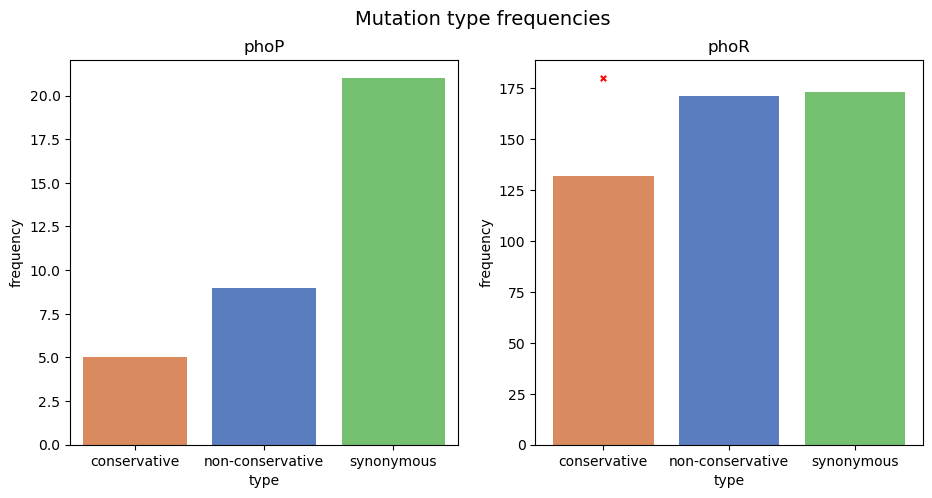

In [33]:
# barplot types summary
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = False, figsize=(11, 5))
sns.barplot(phop_summary_df, ax = ax1, 
            hue_order = ['non-conservative', 'conservative', 'synonymous', 1, 2])
sns.barplot(phor_summary_no_outlier_df, ax = ax2, 
            hue_order = ['non-conservative', 'conservative', 'synonymous', 1, 2])
sns.scatterplot(x = 0, y = 'conservative', data = outlier_180, color = 'red', marker = 'X', ax = ax2, s = 30)
ax1.set_title('phoP')
ax1.set_ylabel('frequency')


ax2.set_title('phoR')
ax2.set_ylabel('frequency')

plt.suptitle('Mutation type frequencies', fontsize = 14)

# Reading in PIPENN-EMB data

In [34]:
# reading in PIPENN-EMB results
phor_pipenn = pd.read_csv('../pipenn/pipenn2_phor_df').drop('Unnamed: 0', axis = 1)
phop_pipenn = pd.read_csv('../pipenn/pipenn2_phop_df').drop('Unnamed: 0', axis = 1)

# Finding most common mutation sites with PIPENN scores > 0.4
## The correlation between mut freq and PIPENN-EMB (with synonymous)

In [35]:
# making a new df containing only the number of amino acid changes
# WITH synonymous mutations
phor_pipenn['position'] = phor_pipenn.index
phor_pip_mut_df = pd.concat([phor_aa_df, phor_pipenn]).groupby('position').sum()
phor_pip_mut_df.drop(['change_aa', 'prot_seq'], axis = 1, inplace = True)
phor_pip_mut_df.rename(columns = {'occurrences': 'mut_freq', 'scaled values': 'mut_scaled',
                                  'prot_seq': 'aa', 'y_preds': 'pipenn_pred'}, inplace = True)
phor_pip_mut_df = phor_pip_mut_df.groupby('position').sum('mut_freq')


In [36]:
# determining correlations between PIPENN-EMB scores and mutation frequencies
np.corrcoef(phor_pip_mut_df[phor_pip_mut_df['mut_freq'] > 0]['pipenn_pred'], phor_pip_mut_df[phor_pip_mut_df['mut_freq'] > 0]['mut_freq'])

array([[ 1.        , -0.14607097],
       [-0.14607097,  1.        ]])

In [37]:
# determining correlations between PIPENN-EMB scores and mutation frequencies
np.corrcoef(phor_pip_mut_df['pipenn_pred'], phor_pip_mut_df['mut_freq'])

array([[ 1.        , -0.05638543],
       [-0.05638543,  1.        ]])

In [38]:
# sort mutation frequencies with PIPENN-EMB scores above 0.4, selecting the top 10
top_df = phor_pip_mut_df[phor_pip_mut_df['pipenn_pred'] > 0.4].sort_values('mut_freq', ascending = False)[:50]

# keeping the position #s for this top 10
phor_indices = list(top_df.index)
top_df

,mut_freq,pipenn_pred
position,,
81,96.0,0.598682
62,60.0,0.703600
70,51.0,0.632985
126,34.0,0.579228
105,15.0,0.443480
425,8.0,0.655692
430,5.0,0.426612
95,4.0,0.768719
274,4.0,0.809026


In [39]:
phor_pip_mut_df.sort_values('mut_freq', ascending = False)[:1]

,mut_freq,pipenn_pred
position,,
171,3135.0,0.100987


In [40]:
# to find mutation types, using the previous indices (see above cell)
# for phor_aa_df to see mutation types and aa changes
phor_aa_df[phor_aa_df['position'].isin(phor_indices)].sort_values('occurrences', ascending = False)

,position,change_dna,change_aa,type,occurrences
16,81,tac -> tat,Y -> Y,synonymous,96
10,62,ccc -> tcc,P -> S,non-conservative,60
11,70,ggt -> att,G -> I,conservative,51
26,126,tta -> tca,L -> S,non-conservative,23
21,105,ccc -> tcc,P -> S,non-conservative,15
27,126,tta -> cta,L -> L,synonymous,11
96,425,gcg -> gtg,A -> V,conservative,8
97,430,ggg -> gtg,G -> V,conservative,5
63,274,tac -> gac,Y -> D,non-conservative,4
18,95,ctc -> cgc,L -> R,non-conservative,4


In [41]:
phor_aa_df.sort_values('occurrences', ascending = False)[:1]

,position,change_dna,change_aa,type,occurrences
38,171,ccc -> ctc,P -> L,conservative,3135


## The correlation between mut freq and PIPENN-EMB (without synonymous)

In [42]:
# making a new df containing only the number of amino acid changes
# WITHOUT synonymous mutations
phor_pipenn['position'] = phor_pipenn.index
ns_phor_pip_mut_df = pd.concat([phor_aa_df[phor_aa_df['type'] != 'synonymous'], phor_pipenn]).groupby('position').sum()
ns_phor_pip_mut_df.drop(['change_aa', 'prot_seq'], axis = 1, inplace = True)
ns_phor_pip_mut_df.rename(columns = {'occurrences': 'mut_freq', 'scaled values': 'mut_scaled',
                                  'prot_seq': 'aa', 'y_preds': 'pipenn_pred'}, inplace = True)
ns_phor_pip_mut_df = ns_phor_pip_mut_df.groupby('position').sum('mut_freq')

In [43]:
# determining correlations between PIPENN-EMB scores and mutation frequencies for residues with more than 0 mutations
np.corrcoef(ns_phor_pip_mut_df[phor_pip_mut_df['mut_freq'] > 0]['pipenn_pred'], ns_phor_pip_mut_df[phor_pip_mut_df['mut_freq'] > 0]['mut_freq'])

array([[ 1.       , -0.1464961],
       [-0.1464961,  1.       ]])

In [44]:
# determining correlations between PIPENN-EMB scores and mutation frequencies
np.corrcoef(ns_phor_pip_mut_df['pipenn_pred'], ns_phor_pip_mut_df['mut_freq'])

array([[ 1.       , -0.0568856],
       [-0.0568856,  1.       ]])

In [45]:
# sort mutation frequencies with PIPENN-EMB scores above 0.4, selecting the top 10
ns_top_df = ns_phor_pip_mut_df[ns_phor_pip_mut_df['pipenn_pred'] > 0.4].sort_values('mut_freq', ascending = False)
ns_top_df = ns_top_df[ns_top_df['mut_freq'] > 0]
# and saving aa positions
ns_phor_indices = list(ns_top_df.index)

In [89]:
# to find mutation types, using the previous indices (see above cell)
# for phor_aa_df to see mutation types and aa changes

report_df = phor_aa_df[(phor_aa_df['position'].isin(ns_phor_indices)) & (phor_aa_df['type'] != 'synonymous')].sort_values('occurrences', ascending = False)
report_df.set_index('position', inplace = True)

for i in ns_top_df.index:
    report_df.loc[i, 'pipenn_pred'] = float(ns_top_df.loc[i, 'pipenn_pred'])

report_df.reset_index(inplace = True)

In [ ]:
# determining blosum scores
# first saving the matrix as a variable
matrix = bl.BLOSUM(62)
val = matrix["A"]["Y"]

In [102]:
blosum62_val = []
for index in report_df.index:
    blosum62_val.append(matrix[report_df.loc[index, 'change_aa'][0]][report_df.loc[index, 'change_aa'][-1]])

report_df['blosum62_score'] = blosum62_val

In [103]:
report_df

,position,change_dna,change_aa,type,occurrences,pipenn_pred,blosum62_score
0,62,ccc -> tcc,P -> S,non-conservative,60,0.703600,-1.0
1,70,ggt -> att,G -> I,conservative,51,0.632985,-4.0
2,126,tta -> tca,L -> S,non-conservative,23,0.579228,-2.0
3,105,ccc -> tcc,P -> S,non-conservative,15,0.443480,-1.0
4,425,gcg -> gtg,A -> V,conservative,8,0.655692,0.0
5,430,ggg -> gtg,G -> V,conservative,5,0.426612,-3.0
6,274,tac -> gac,Y -> D,non-conservative,4,0.809026,-3.0
7,95,ctc -> cgc,L -> R,non-conservative,4,0.768719,-2.0
8,290,gag -> gcg,E -> A,non-conservative,3,0.698424,-1.0
9,422,tcg -> gcg,S -> A,non-conservative,3,0.768064,1.0


In [104]:
# saving for report
report_df.to_csv('./non_synonymous_top_mut.csv')

# Making .defattr files for ChimeraX

## Preparing data

In [50]:
# passing function that sums NON-SYNONYMOUS mutations from phor and phop
phop_sum_df  = simple_df(phop_aa_df, ['change_aa', 'type'], phop_aa)
phor_sum_df  = simple_df(phor_aa_df, ['change_aa', 'type'], phor_aa)

# saving the sum dataframes for use in other notebooks
%store phor_sum_df
%store phop_sum_df

Stored 'phor_sum_df' (DataFrame)
Stored 'phop_sum_df' (DataFrame)


In [51]:
phor_sum_df.sort_values('scaled values', ascending = False)

,occurrences,scaled values
position,,
171,3135,1.000000
62,60,0.019139
70,51,0.016268
126,23,0.007337
394,17,0.005423
...,...,...
172,0,0.000000
170,0,0.000000
169,0,0.000000


## Make .defattr files

In [52]:
# applying make_defattr function to create files for ChimeraX mapping
make_defattr(phor_sum_df, 'mutation_frequency', 'phor_mut_tot_2', 'scaled values', 'PhoR')
make_defattr(phop_sum_df, 'mutation_frequency', 'phop_mut_tot_2', 'scaled values', 'PhoP')

make_defattr(phor_pipenn, 'pipenn_scores', 'phor_pipenn_2', 'y_preds', 'PhoR')
make_defattr(phop_pipenn, 'pipenn_scores', 'phop_pipenn_2', 'y_preds', 'PhoP')